### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import preprocess.view_utils as view_utils

In [3]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
import skimage.io as io
import openslide

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from utils.patches import *

In [7]:
import warnings
warnings.filterwarnings('ignore')

### Validation dataset

In [8]:
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import PatchDataset

In [9]:
slide_level = 2
patch_len = 256
stride_len = 64
normalize = False
seed = 2020

In [10]:
data_augmentation, img_size, crop_size = "none", 256, 256
train_aug, train_aug_img, val_aug = data_augmentation_selector(data_augmentation, img_size, crop_size)

Using None Data Augmentation


In [11]:
val_dataset = PatchDataset(
    "validation", slide_level, patch_len, stride_len, val_aug, [],
    normalize=normalize, patch_type="all", seed=seed
)

### Predict

In [41]:
import torch
from torch.utils.data import DataLoader
from utils.dataload import mask_loader, PatchArrayDataset
from models import *

In [42]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
model_name = "resnet34_unet_imagenet_encoder"
crop_size = 256
model = model_selector(model_name, in_size=(crop_size, crop_size))
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))


--- Frosted pretrained backbone! ---


In [57]:
model_checkpoint = "../results/lvl2_patch256_stride64/samples_20000/resnet34_unet_imagenet_encoder/adam/bce_dice/weights0.1,0.85,0.05_danone_minlr0.0001_maxlr0.01/model_resnet34_unet_imagenet_encoder_last.pt"
model.load_state_dict(torch.load(model_checkpoint))

<All keys matched successfully>

In [58]:
slide_names = val_dataset.get_slide_filenames()
for num, (cur_slide_path, cur_mask_path) in enumerate(slide_names):
    # Load WSI
    mask = mask_loader(cur_mask_path)
    
    wsi_head = openslide.OpenSlide(cur_slide_path)
    slide_img = wsi_head.read_region(
        (0, 0), val_dataset.slide_level, wsi_head.level_dimensions[val_dataset.slide_level]
    )
    pred_h = wsi_head.level_dimensions[val_dataset.slide_level][1]
    pred_w = wsi_head.level_dimensions[val_dataset.slide_level][0]
    slide_img = np.asarray(slide_img)[:, :, :3]  # Quitamos el canal alpha ya que no tiene información relevante
    break

In [59]:
coors_arr = wsi_stride_splitting(pred_h, pred_w, val_dataset.patch_len, val_dataset.stride_len)
patch_arr, wmap = gen_patch_wmap(slide_img, coors_arr, val_dataset.patch_len)

In [60]:
batch_size = 24
patch_dset = PatchArrayDataset(patch_arr, val_dataset.transform, val_dataset.img_transform)
patch_loader = DataLoader(patch_dset, batch_size=batch_size, shuffle=False, drop_last=False)
pred_map = np.zeros_like(wmap).astype(np.float32)

In [47]:
with torch.no_grad():
    for ind, patches in enumerate(tqdm(patch_loader)):
        inputs = patches.cuda()
        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            preds = torch.squeeze(preds, dim=1).data.cpu().numpy()
            if (ind + 1) * batch_size <= len(coors_arr):
                patch_coors = coors_arr[ind * batch_size:(ind + 1) * batch_size]
            else:
                patch_coors = coors_arr[ind * batch_size:]
            for ind_coor, coor in enumerate(patch_coors):
                ph, pw = coor[0], coor[1]
                pred_map[ph:ph + val_dataset.patch_len, pw:pw + val_dataset.patch_len] += preds[ind_coor]

In [48]:
prob_pred = np.divide(pred_map, wmap)

In [55]:
binary_threshold = 0.5
y_pred = (prob_pred > binary_threshold).astype(np.uint8)

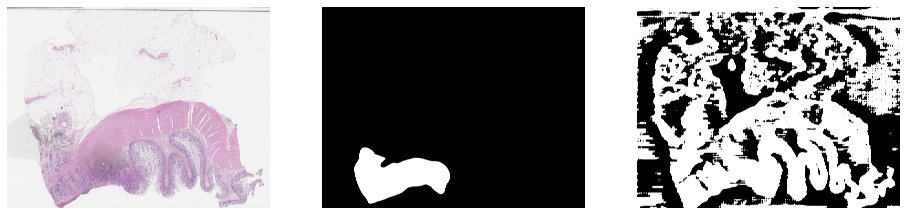

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 16))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(slide_img)
ax2.imshow(mask, cmap="gray")
ax3.imshow(y_pred, cmap="gray")
plt.savefig("pred.png", bbox_inches='tight', pad_inches=0.25, dpi=250)

In [ ]:
io.imsave(pred_save_path, slide_pred*255)